# Auto Grading using Transformers

## Install all the required libraries

In [1]:
! pip install datasets
! pip install -U accelerate
! pip install -U transformers
! pip install torchinfo
! pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00


## Import all the required libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch
import wandb
import math

from transformers import pipeline
from transformers import AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
from pprint import pprint

from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import cohen_kappa_score

### Log on to weights and biases

In [3]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [4]:
torch.cuda.is_available()
torch.cuda.current_device()

0

## Loading Data

In [5]:
# Training set
df_ = pd.read_excel('/content/training_set_rel3.xlsx')
df = df_[['domain1_score', 'essay', 'essay_set']].copy()

# Validation Set complete
df_v = pd.read_excel('/content/validation_set_complete.xlsx')
df_val = df_v[['predicted_score', 'essay', 'essay_set']].copy()

In [6]:
# Only use Essay Set #1
df_essay1_train = df[df.essay_set == 1].copy()
df_essay1_validation = df_val[df_val.essay_set == 1].copy()
# df_essay1_test = df_test[df_test.essay_set == 1].copy()

# Only use Essay Set #2
df_essay2_train = df[df.essay_set == 2].copy()
df_essay2_validation = df_val[df_val.essay_set == 2].copy()
# df_essay2_test = df_test[df_test.essay_set == 2].copy()

# Only use Essay Set #3
df_essay3_train = df[df.essay_set == 3].copy()
df_essay3_validation = df_val[df_val.essay_set == 3].copy()
# df_essay3_test = df_test[df_test.essay_set == 3].copy()

# Only use Essay Set #4
df_essay4_train = df[df.essay_set == 4].copy()
df_essay4_validation = df_val[df_val.essay_set == 4].copy()
# df_essay4_test = df_test[df_test.essay_set == 4].copy()

# Only use Essay Set #5
df_essay5_train = df[df.essay_set == 5].copy()
df_essay5_validation = df_val[df_val.essay_set == 5].copy()
# df_essay5_test = df_test[df_test.essay_set == 5].copy()

# Only use Essay Set #6
df_essay6_train = df[df.essay_set == 6].copy()
df_essay6_validation = df_val[df_val.essay_set == 6].copy()
# df_essay6_test = df_test[df_test.essay_set == 6].copy()

# Only use Essay Set #7
df_essay7_train = df[df.essay_set == 7].copy()
df_essay7_validation = df_val[df_val.essay_set == 7].copy()
# df_essay7_test = df_test[df_test.essay_set == 7].copy()

# Only use Essay Set #8
df_essay8_train = df[df.essay_set == 8].copy()
df_essay8_validation = df_val[df_val.essay_set == 8].copy()
# df_essay8_test = df_test[df_test.essay_set == 8].copy()

In [7]:
# Function to convert scores into classifications

def map_float_to_category(number):
    if 2 <= number <= 7:
        return 0 #low
    elif number == 8:
        return 1 #medium
    elif 9 <= number <= 12:
        return 2 #high
    else:
        return 'unknown'

def map_float_to_category_set2(number):
    if 1 <= number <= 2:
        return 0 #low
    elif 3 <= number <= 4:
        return 1 #medium
    elif 5 <= number <= 6:
        return 2 #high
    else:
        return 'unknown'


def map_float_to_category_set3_4(number):
    if 0 <= number <= 1:
        return 0 #low
    elif number == 2:
        return 1 #medium
    elif number == 3:
        return 2 #high
    else:
        return 'unknown'


def map_float_to_category_set5_6(number):
    if 0 <= number <= 1:
        return 0 #low
    elif number == 2:
        return 1 #medium
    elif 3 <= number <= 4:
        return 2 #high
    else:
        return 'unknown'

def map_float_to_category_set7(number):
    if 0 <= number <= 12:
        return 0 #low
    elif 13 <= number <= 19:
        return 1 #medium
    elif 20 <= number <= 30:
        return 2 #high
    else:
        return 'unknown'

def map_float_to_category_set8(number):
    if 0 <= number <= 31:
        return 0 #low
    elif 32 <= number <= 38:
        return 1 #medium
    elif 39 <= number <= 60:
        return 2 #high
    else:
        return 'unknown'

In [8]:
# Model training data
df_essay1_train['target'] = df_essay1_train['domain1_score'].map(map_float_to_category)
df_essay2_train['target'] = df_essay2_train['domain1_score'].map(map_float_to_category_set2)
df_essay3_train['target'] = df_essay3_train['domain1_score'].map(map_float_to_category_set3_4)
df_essay4_train['target'] = df_essay4_train['domain1_score'].map(map_float_to_category_set3_4)
df_essay5_train['target'] = df_essay5_train['domain1_score'].map(map_float_to_category_set5_6)
df_essay6_train['target'] = df_essay6_train['domain1_score'].map(map_float_to_category_set5_6)
df_essay7_train['target'] = df_essay7_train['domain1_score'].map(map_float_to_category_set7)
df_essay8_train['target'] = df_essay8_train['domain1_score'].map(map_float_to_category_set8)

In [9]:
# Model validation data
df_essay1_validation['target'] = df_essay1_validation['predicted_score'].map(map_float_to_category)
df_essay2_validation['target'] = df_essay2_validation['predicted_score'].map(map_float_to_category_set2)
df_essay3_validation['target'] = df_essay3_validation['predicted_score'].map(map_float_to_category_set3_4)
df_essay4_validation['target'] = df_essay4_validation['predicted_score'].map(map_float_to_category_set3_4)
df_essay5_validation['target'] = df_essay5_validation['predicted_score'].map(map_float_to_category_set5_6)
df_essay6_validation['target'] = df_essay6_validation['predicted_score'].map(map_float_to_category_set5_6)
df_essay7_validation['target'] = df_essay7_validation['predicted_score'].map(map_float_to_category_set7)
df_essay8_validation['target'] = df_essay8_validation['predicted_score'].map(map_float_to_category_set8)

In [10]:
# Drop null values on set 4
df_essay4_train.dropna(inplace=True)
df_essay4_train.isnull().sum()

domain1_score    0
essay            0
essay_set        0
target           0
dtype: int64

In [11]:
df_train_final = pd.concat([df_essay1_train[['essay', 'target']], df_essay2_train[['essay', 'target']], df_essay3_train[['essay', 'target']],
                            df_essay4_train[['essay', 'target']], df_essay5_train[['essay', 'target']], df_essay6_train[['essay', 'target']],
                            df_essay7_train[['essay', 'target']], df_essay8_train[['essay', 'target']]], axis=0)

In [12]:
df_val_final = pd.concat([df_essay1_validation[['essay', 'target']], df_essay2_validation[['essay', 'target']], df_essay3_validation[['essay', 'target']],
                            df_essay4_validation[['essay', 'target']], df_essay5_validation[['essay', 'target']], df_essay6_validation[['essay', 'target']],
                            df_essay7_validation[['essay', 'target']], df_essay8_validation[['essay', 'target']]], axis=0)


## Visualing data

<Axes: >

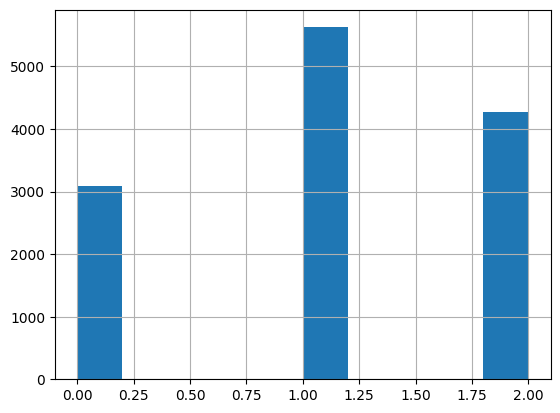

In [13]:
# Check for imbalance on the targets
df_train_final['target'].hist()

In [14]:
# Prepare Train data for transformer models
df_final = df_train_final[['essay', 'target']]
df_final.columns = ['sentence', 'label']
df_final.to_csv('train_data.csv', index=None)

# Prepare Validation data for transformer models
df_val = df_val_final[['essay', 'target']]
df_val.columns = ['sentence', 'label']
df_val.to_csv('val_data.csv', index=None)

In [15]:
!head train_data.csv

sentence,label
"Dear local newspaper, I think effects computers have on people are great learning skills/affects because they give us time to chat with friends/new people, helps us learn about the globe(astronomy) and keeps us out of troble! Thing about! Dont you think so? How would you feel if your teenager is always on the phone with friends! Do you ever time to chat with your friends or buisness partner about things. Well now - there's a new way to chat the computer, theirs plenty of sites on the internet to do so: @ORGANIZATION1, @ORGANIZATION2, @CAPS1, facebook, myspace ect. Just think now while your setting up meeting with your boss on the computer, your teenager is having fun on the phone not rushing to get off cause you want to use it. How did you learn about other countrys/states outside of yours? Well I have by computer/internet, it's a new way to learn about what going on in our time! You might think your child spends a lot of time on the computer, but ask them so question a

In [16]:
# For an existing train-test split:
raw_dataset = load_dataset(
    'csv',
    data_files={'train': 'train_data.csv',
                'validation': 'val_data.csv'
    }
)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [17]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 12977
    })
    validation: Dataset({
        features: ['sentence', 'label'],
        num_rows: 589
    })
})

In [18]:
split = raw_dataset['train'].train_test_split(test_size=0.3, seed=42)

In [19]:
split['train']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 9083
})

# Model Preparation

In [20]:
checkpoint = 'EleutherAI/gpt-neo-125m'

from transformers import AutoTokenizer, GPTNeoConfig, GPTNeoForSequenceClassification

# Initializing a GPT-Neo
configuration = GPTNeoConfig()

tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

## Unsupervised Fine tuning on Computer Sciency Wikipedia Corpus

In [21]:
# Wiki Fine tuning dataset
tune_dataset = load_dataset('text', data_files='/content/cs_file.txt')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [22]:
tune_dataset.shape

{'train': (169995, 1)}

In [23]:
wiki_dataset = tune_dataset['train'].train_test_split(test_size=0.3, seed=42)

In [24]:
wiki_dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 118996
    })
    test: Dataset({
        features: ['text'],
        num_rows: 50999
    })
})

In [25]:
from datasets import ClassLabel
import random
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [26]:
show_random_elements(wiki_dataset["train"])

,text
0,
1,"DSS also have a weak connection to the user interface paradigm of hypertext. Both the University of Vermont PROMIS system (for medical decision making) and the Carnegie Mellon ZOG/KMS system (for military and business decision making) were decision support systems which also were major breakthroughs in user interface research. Furthermore, although hypertext researchers have generally been concerned with information overload, certain researchers, notably Douglas Engelbart, have been focused on decision makers in particular."
2,
3,with joined or fused petals
4,=== Accessibility features in mainstream software ===
5,"The theory that people optimally change their behaviour in response to policy changes. Depending on the situation, their behavioural changes can greatly limit the effectiveness of policy changes."
6,
7,== References ==
8,for each task: . This results in the regularized machine learning problem:
9,"Fallis, D. (2000). ""The reliability of randomized algorithms"". The British Journal for the Philosophy of Science. 51 (2): 255–271. doi:10.1093/bjps/51.2.255."


In [27]:
def tokenize_function(examples):
    return tokenizer(examples["text"])

In [28]:
tokenized_data = wiki_dataset.map(tokenize_function, batched=True, num_proc=4, remove_columns=["text"])

Map (num_proc=4):   0%|          | 0/118996 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/50999 [00:00<?, ? examples/s]

In [29]:
# block_size = tokenizer.model_max_length
block_size = 128

In [30]:
#  Preprocessing function that will group our texts:
def group_texts(examples):
    # Concatenate all texts.
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    total_length = (total_length // block_size) * block_size
    # Split by chunks of max_len.
    result = {
        k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
        for k, t in concatenated_examples.items()
    }
    result["labels"] = result["input_ids"].copy()
    return result

In [31]:
lm_datasets = tokenized_data.map(
    group_texts,
    batched=True,
    batch_size=1000,
    num_proc=4,
)

Map (num_proc=4):   0%|          | 0/118996 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/50999 [00:00<?, ? examples/s]

In [32]:
lm_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 18626
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 8050
    })
})

In [33]:
tokenizer.decode(lm_datasets["train"][1]["input_ids"])

' use those resources elsewhere. Again, ideal risk management minimizes spending (or manpower or other resources) and also minimizes the negative effects of risks.A unit of energy equal to approximately 1.6×10−19 joule. By definition, it is the amount of energy gained by the charge of a single electron moved across an electric potential difference of one volt.Virtual reality                    {\\displaystyle {\\ce {HA <=> H+ + A-}}}        A computer system intended to converse with a'

In [34]:
# Initializing a model

from transformers import AutoModelForCausalLM
wiki_model = AutoModelForCausalLM.from_pretrained(checkpoint)

wiki_model.config.pad_token_id = wiki_model.config.eos_token_id

model.safetensors:   0%|          | 0.00/526M [00:00<?, ?B/s]

In [35]:
model_name = checkpoint.split("/")[-1]
training_args = TrainingArguments(
    f"{model_name}-finetuned-wikitext",
    report_to="wandb",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    # push_to_hub=True,
)

In [36]:
wiki_trainer = Trainer(
    model=wiki_model,
    args=training_args,
    train_dataset=lm_datasets["train"],
    eval_dataset=lm_datasets["test"],
    tokenizer=tokenizer,
)

In [37]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [38]:
wiki_trainer.train()

wandb: Currently logged in as: 2468512. Use `wandb login --relogin` to force relogin


You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss
1,3.195800,3.187575
2,3.046300,3.155037
3,2.958900,3.149693


TrainOutput(global_step=6987, training_loss=3.0803797279490035, metrics={'train_runtime': 997.1643, 'train_samples_per_second': 56.037, 'train_steps_per_second': 7.007, 'total_flos': 3648932546347008.0, 'train_loss': 3.0803797279490035, 'epoch': 3.0})

In [39]:
# Check Perplexity
eval_results = wiki_trainer.evaluate()
print(f"Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

Perplexity: 23.33


In [40]:
wiki_trainer.save_model('wiki_model')


## Prepare supervised training data

In [41]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'], padding='max_length', truncation=True, return_tensors="pt")

In [42]:
tokenized_datasets = split.map(tokenize_fn, batched=True)

Map:   0%|          | 0/9083 [00:00<?, ? examples/s]

Map:   0%|          | 0/3894 [00:00<?, ? examples/s]

In [43]:
# dir(tokenized_datasets)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 9083
    })
    test: Dataset({
        features: ['sentence', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3894
    })
})

## Initialising model

In [132]:
model = GPTNeoForSequenceClassification(configuration).from_pretrained('/content/wiki_model', num_labels=3)
model.config.pad_token_id = model.config.eos_token_id

Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at /content/wiki_model and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [133]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                  Param #
GPTNeoForSequenceClassification                         --
├─GPTNeoModel: 1-1                                      --
│    └─Embedding: 2-1                                   38,597,376
│    └─Embedding: 2-2                                   1,572,864
│    └─Dropout: 2-3                                     --
│    └─ModuleList: 2-4                                  --
│    │    └─GPTNeoBlock: 3-1                            7,085,568
│    │    └─GPTNeoBlock: 3-2                            7,085,568
│    │    └─GPTNeoBlock: 3-3                            7,085,568
│    │    └─GPTNeoBlock: 3-4                            7,085,568
│    │    └─GPTNeoBlock: 3-5                            7,085,568
│    │    └─GPTNeoBlock: 3-6                            7,085,568
│    │    └─GPTNeoBlock: 3-7                            7,085,568
│    │    └─GPTNeoBlock: 3-8                            7,085,568
│    │    └─GPTNeoBlock: 3-9           

## Training and parameter tuning

In [135]:
training_args = TrainingArguments(
  # report_to='none',
  report_to="wandb",
  output_dir='training_mod',
  evaluation_strategy='epoch',
  save_strategy='epoch',
  num_train_epochs=2,
  learning_rate=1e-4,
  weight_decay=0.01,
  load_best_model_at_end = True,
  per_device_train_batch_size=1,
  per_device_eval_batch_size=1,
)

In [136]:
def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy': acc, 'f1': f1}

In [137]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [138]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [139]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.497300,1.483744,0.682589,0.672459
2,1.434800,1.403950,0.716230,0.716693


TrainOutput(global_step=18166, training_loss=1.4576581312173476, metrics={'train_runtime': 4398.1086, 'train_samples_per_second': 4.13, 'train_steps_per_second': 4.13, 'total_flos': 1.898086682905805e+16, 'train_loss': 1.4576581312173476, 'epoch': 2.0})

In [140]:
wandb.finish()

eval/accuracy,▁█
eval/f1,▁█
eval/loss,█▁
eval/runtime,▁█
eval/samples_per_second,█▁
eval/steps_per_second,█▁
train/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
train/learning_rate,███▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
train/loss,▆█▄▃▃▅▄▄▃▄▄▄▄▃▃▃▃▄▂▂▃▃▂▃▃▃▂▂▃▁▃▃▃▃▃▃
train/total_flos,▁


In [141]:
!ls training_mod

checkpoint-18166  checkpoint-9083


In [142]:
trainer.save_model('my_model')

In [143]:
!ls my_saved_model

config.json  model.safetensors	      tokenizer_config.json  training_args.bin
merges.txt   special_tokens_map.json  tokenizer.json	     vocab.json


## Testing the saved Model

### Prepare Test Data

In [144]:
raw_dataset['validation']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 589
})

In [145]:
# Function to convert labels to integers
def get_label(d):
  return int(d['label'].split('_')[1])


### Test Baseline Model

In [146]:
rawmodel = pipeline('text-classification',  model =checkpoint, device=0)

Some weights of GPTNeoForSequenceClassification were not initialized from the model checkpoint at EleutherAI/gpt-neo-125m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [147]:
test_pred = rawmodel(raw_dataset['validation']['sentence'])

In [148]:
test_pred[0]

{'label': 'LABEL_0', 'score': 0.8744529485702515}

In [149]:
test_pred = [get_label(d) for d in test_pred]

In [150]:
print("acc:", accuracy_score(raw_dataset['validation']['label'], test_pred))

acc: 0.1799660441426146


In [151]:
print("f1:", f1_score(raw_dataset['validation']['label'], test_pred, average='macro'))

f1: 0.13299123089071316


In [152]:
# Calculate QWK
qwk_score = cohen_kappa_score(raw_dataset['validation']['label'], test_pred, weights='quadratic')
print("Quadratic Weighted Kappa Score:", qwk_score)

Quadratic Weighted Kappa Score: 0.013061812065213507


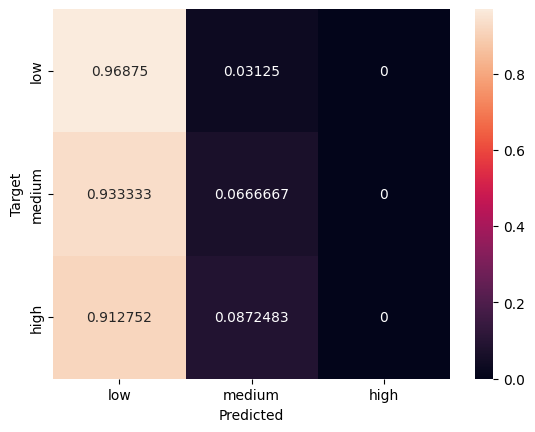

In [153]:
# The Confusion Matrix
def plot_cm(cm):
  classes = ['low', 'medium', 'high']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

cm = confusion_matrix(raw_dataset['validation']['label'], test_pred, normalize='true')
plot_cm(cm)

### Test Fine tuned wiki model

In [154]:
# Classification without wiki corpus
unsupervised = pipeline('text-classification', model='/content/training_dir/checkpoint-18168', device=0)


In [155]:
test_preds = unsupervised(raw_dataset['validation']['sentence'])

In [156]:
test_preds[0]

{'label': 'LABEL_1', 'score': 0.994205892086029}

In [157]:
test_preds = [get_label(d) for d in test_preds]

In [158]:
print("acc:", accuracy_score(raw_dataset['validation']['label'], test_preds))

acc: 0.7555178268251274


In [159]:
print("f1:", f1_score(raw_dataset['validation']['label'], test_preds, average='macro'))

f1: 0.7582723588493777


In [160]:
# Calculate QWK
qwk_score = cohen_kappa_score(raw_dataset['validation']['label'], test_pred, weights='quadratic')
print("Quadratic Weighted Kappa Score:", qwk_score)

Quadratic Weighted Kappa Score: 0.013061812065213507


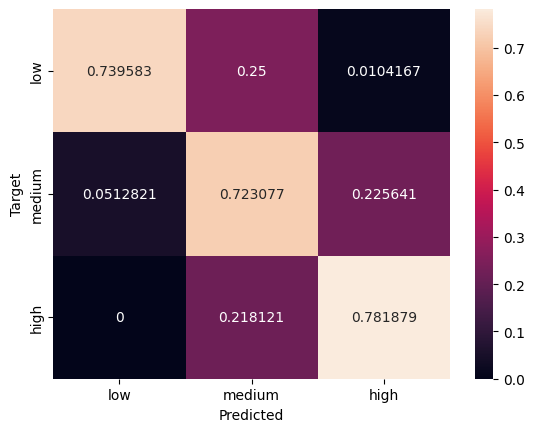

In [161]:
# The Confusion Matrix
def plot_cm(cm):
  classes = ['low', 'medium', 'high']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

cm = confusion_matrix(raw_dataset['validation']['label'], test_preds, normalize='true')
plot_cm(cm)

## Test fine tuned model

In [187]:
# Saved Model
savedmodel = pipeline('text-classification',  model ='my_model', device=0)

In [188]:
test_pret = savedmodel(raw_dataset['validation']['sentence'])

In [189]:
test_pret = [get_label(d) for d in test_pret]

In [190]:
print("acc:", accuracy_score(raw_dataset['validation']['label'], test_pret))

acc: 0.6740237691001698


In [191]:
print("f1:", f1_score(raw_dataset['validation']['label'], test_pret, average='macro'))

f1: 0.5412838935471703


In [192]:
# Calculate QWK
qwk_score = cohen_kappa_score(raw_dataset['validation']['label'], test_pret, weights='quadratic')
print("Quadratic Weighted Kappa Score:", qwk_score)

Quadratic Weighted Kappa Score: 0.5652737274764061


In [193]:
# !cat my_saved_model/config.json

In [194]:
# import json

# config_path = 'my_saved_model/config.json'
# with open(config_path) as f:
#   j = json.load(f)

# j['id2label'] = {0: 'LABEL_0', 1: 'LABEL_1', 2: 'LABEL_2'}
# # j['id2label'] = {'low': 0, 'medium':1, 'high':2 }

# with open(config_path, 'w') as f:
#   json.dump(j, f, indent=2)

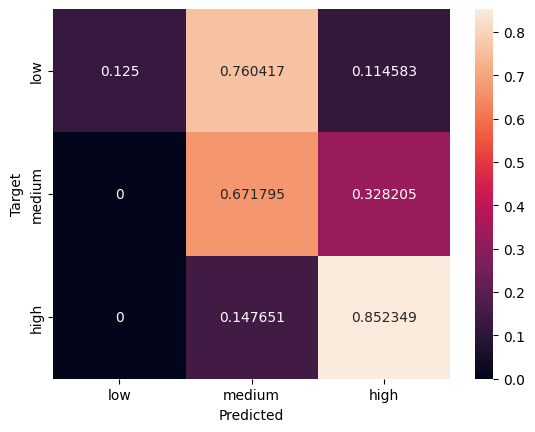

In [195]:
# The Confusion Matrix
def plot_cm(cm):
  classes = ['low', 'medium', 'high']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

cm = confusion_matrix(raw_dataset['validation']['label'], test_pret, normalize='true')
plot_cm(cm)

## END